In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

movies_df = pd.read_csv('./moviedata/movies.csv')
ratings_df = pd.read_csv('./moviedata/ratings.csv')
tags_df = pd.read_csv('./moviedata/tags.csv')

#Display Data Samp
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [2]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [4]:
#as we can see the tables are related to each other through common keys
#These tables are likely related to each other through movieIds or userIds 
#So we will combine the tables into a single table

# Merge tags_df with ratings_df based on movieId and userId
merged_df = pd.merge(tags_df, ratings_df, on=['movieId', 'userId'], how='left')

merged_df.head()

,userId,movieId,tag,timestamp_x,rating,timestamp_y
0,2,60756,funny,1445714994,5.0,1.445715e+09
1,2,60756,Highly quotable,1445714996,5.0,1.445715e+09
2,2,60756,will ferrell,1445714992,5.0,1.445715e+09
3,2,89774,Boxing story,1445715207,5.0,1.445715e+09
4,2,89774,MMA,1445715200,5.0,1.445715e+09


In [5]:
# Merge merged_df with movies_df based on movieId
combined_df = pd.merge(merged_df, movies_df, on='movieId', how='left')
combined_df.head()

,userId,movieId,tag,timestamp_x,rating,timestamp_y,title,genres
0,2,60756,funny,1445714994,5.0,1.445715e+09,Step Brothers (2008),Comedy
1,2,60756,Highly quotable,1445714996,5.0,1.445715e+09,Step Brothers (2008),Comedy
2,2,60756,will ferrell,1445714992,5.0,1.445715e+09,Step Brothers (2008),Comedy
3,2,89774,Boxing story,1445715207,5.0,1.445715e+09,Warrior (2011),Drama
4,2,89774,MMA,1445715200,5.0,1.445715e+09,Warrior (2011),Drama


In [6]:
# Rename 'timestamp_x' to 'tag_timestamp'
combined_df.rename(columns={'timestamp_x': 'tag_timestamp'}, inplace=True)

# Rename 'timestamp_y' to 'rating_timestamp'
combined_df.rename(columns={'timestamp_y': 'rating_timestamp'}, inplace=True)

# Convert 'tag_timestamp' columns to datetime format
combined_df['tag_timestamp'] = pd.to_datetime(combined_df['tag_timestamp'], unit='s')

# Convert 'rating_timestamp' columns to datetime format
combined_df['rating_timestamp'] = pd.to_datetime(combined_df['rating_timestamp'], unit='s')

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   userId            3683 non-null   int64         
 1   movieId           3683 non-null   int64         
 2   tag               3683 non-null   object        
 3   tag_timestamp     3683 non-null   datetime64[ns]
 4   rating            3476 non-null   float64       
 5   rating_timestamp  3476 non-null   datetime64[ns]
 6   title             3683 non-null   object        
 7   genres            3683 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 230.3+ KB


In [7]:
# Drop duplicate entries
combined_df.drop_duplicates(inplace=True)

combined_df.isnull().sum()

userId                0
movieId               0
tag                   0
tag_timestamp         0
rating              207
rating_timestamp    207
title                 0
genres                0
dtype: int64

In [8]:
#we have some messing values in two columns rating, rating_timestamp so we will calculate the outliers 
#calculate the IQR and upper/lower bounds for 'rating' column
Q1 = combined_df['rating'].quantile(.25)
Q3 = combined_df['rating'].quantile(.75)
IQR = Q3 - Q1 
IQR

1.5

In [9]:
RV = Q1 - (1.5*IQR)
LV = Q3 + (1.5 *IQR) 
RV,LV

(1.25, 7.25)

In [10]:
combined_df['rating'].describe()

count    3476.000000
mean        4.016830
std         0.856925
min         0.500000
25%         3.500000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

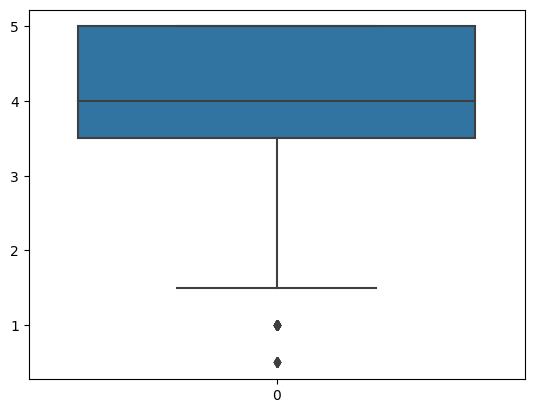

In [11]:
#we will boxplot the rating data to see outliers 
sns.boxplot(combined_df['rating'])
plt.show()

In [12]:
#we will see the number of values which are greater than 5 in the below cells and value less than 1.5
df1 = combined_df['rating']>5
df1.value_counts()

rating
False    3683
Name: count, dtype: int64

In [13]:
df2 = combined_df['rating']<1.5
df2.value_counts()

rating
False    3644
True       39
Name: count, dtype: int64

In [14]:
#As there are outliers present here we will replace the null values with median
#first I have another way to calculate outliers to make sure 
outliers = combined_df[(combined_df['rating']<RV)|(combined_df['rating']>LV)]
outliers

,userId,movieId,tag,tag_timestamp,rating,rating_timestamp,title,genres
9,7,48516,way too long,2007-01-25 01:08:45,1.0,2007-01-25 01:08:38,"Departed, The (2006)",Crime|Drama|Thriller
29,21,119141,bloody,2014-12-28 19:12:42,0.5,2014-12-28 19:12:19,The Interview (2014),Action|Comedy
212,62,63992,audience intelligence underestimated,2018-06-13 23:57:17,1.0,2018-06-13 23:57:05,Twilight (2008),Drama|Fantasy|Romance|Thriller
213,62,63992,boring,2018-06-13 23:57:21,1.0,2018-06-13 23:57:05,Twilight (2008),Drama|Fantasy|Romance|Thriller
214,62,63992,chick flick,2018-06-13 23:57:27,1.0,2018-06-13 23:57:05,Twilight (2008),Drama|Fantasy|Romance|Thriller
215,62,63992,overrated,2018-06-13 23:57:20,1.0,2018-06-13 23:57:05,Twilight (2008),Drama|Fantasy|Romance|Thriller
216,62,63992,Teen movie,2018-06-13 23:57:13,1.0,2018-06-13 23:57:05,Twilight (2008),Drama|Fantasy|Romance|Thriller
573,305,6953,DEPRESSING,2016-05-04 21:40:32,1.0,2016-05-05 18:45:01,21 Grams (2003),Crime|Drama|Mystery|Romance|Thriller
967,424,112556,annoying,2016-03-13 04:58:08,1.0,2016-03-13 04:59:39,Gone Girl (2014),Drama|Thriller
968,424,112556,Stupid ending,2016-03-13 04:59:15,1.0,2016-03-13 04:59:39,Gone Girl (2014),Drama|Thriller


In [15]:
combined_df['rating'] = combined_df['rating'].replace(np.nan, combined_df['rating'].median())

In [16]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   userId            3683 non-null   int64         
 1   movieId           3683 non-null   int64         
 2   tag               3683 non-null   object        
 3   tag_timestamp     3683 non-null   datetime64[ns]
 4   rating            3683 non-null   float64       
 5   rating_timestamp  3476 non-null   datetime64[ns]
 6   title             3683 non-null   object        
 7   genres            3683 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 230.3+ KB


In [17]:
# Now we have to deal with the rating_timestamp so we will do time-based interpolation 
# Sort the DataFrame by timestamp before interpolating
combined_df.sort_values(by='rating_timestamp', inplace=True)

# Interpolate missing timestamps
combined_df['rating_timestamp'].interpolate(method='pad', inplace=True)

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3683 entries, 1269 to 3679
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   userId            3683 non-null   int64         
 1   movieId           3683 non-null   int64         
 2   tag               3683 non-null   object        
 3   tag_timestamp     3683 non-null   datetime64[ns]
 4   rating            3683 non-null   float64       
 5   rating_timestamp  3683 non-null   datetime64[ns]
 6   title             3683 non-null   object        
 7   genres            3683 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 259.0+ KB


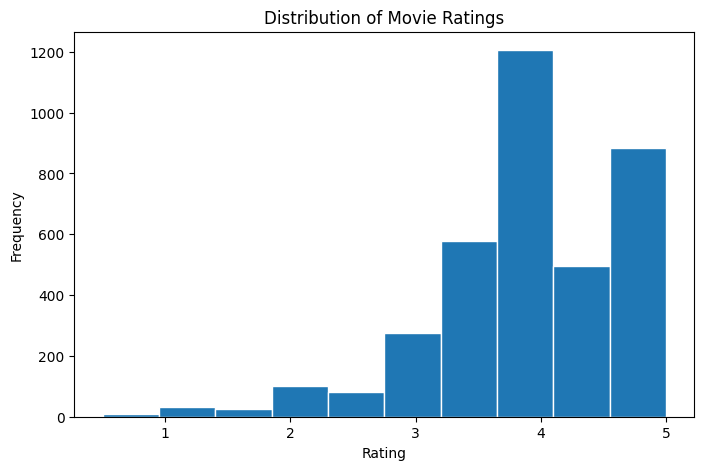

In [18]:
# NOW ANALYSIS 
#first let's start with "Distribution of Ratings". Let's plot the distribution of movie ratings to understand the distribution of user preferences
plt.figure(figsize=(8, 5))
plt.hist(combined_df['rating'], bins=10, edgecolor='white')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Ratings')
plt.show()

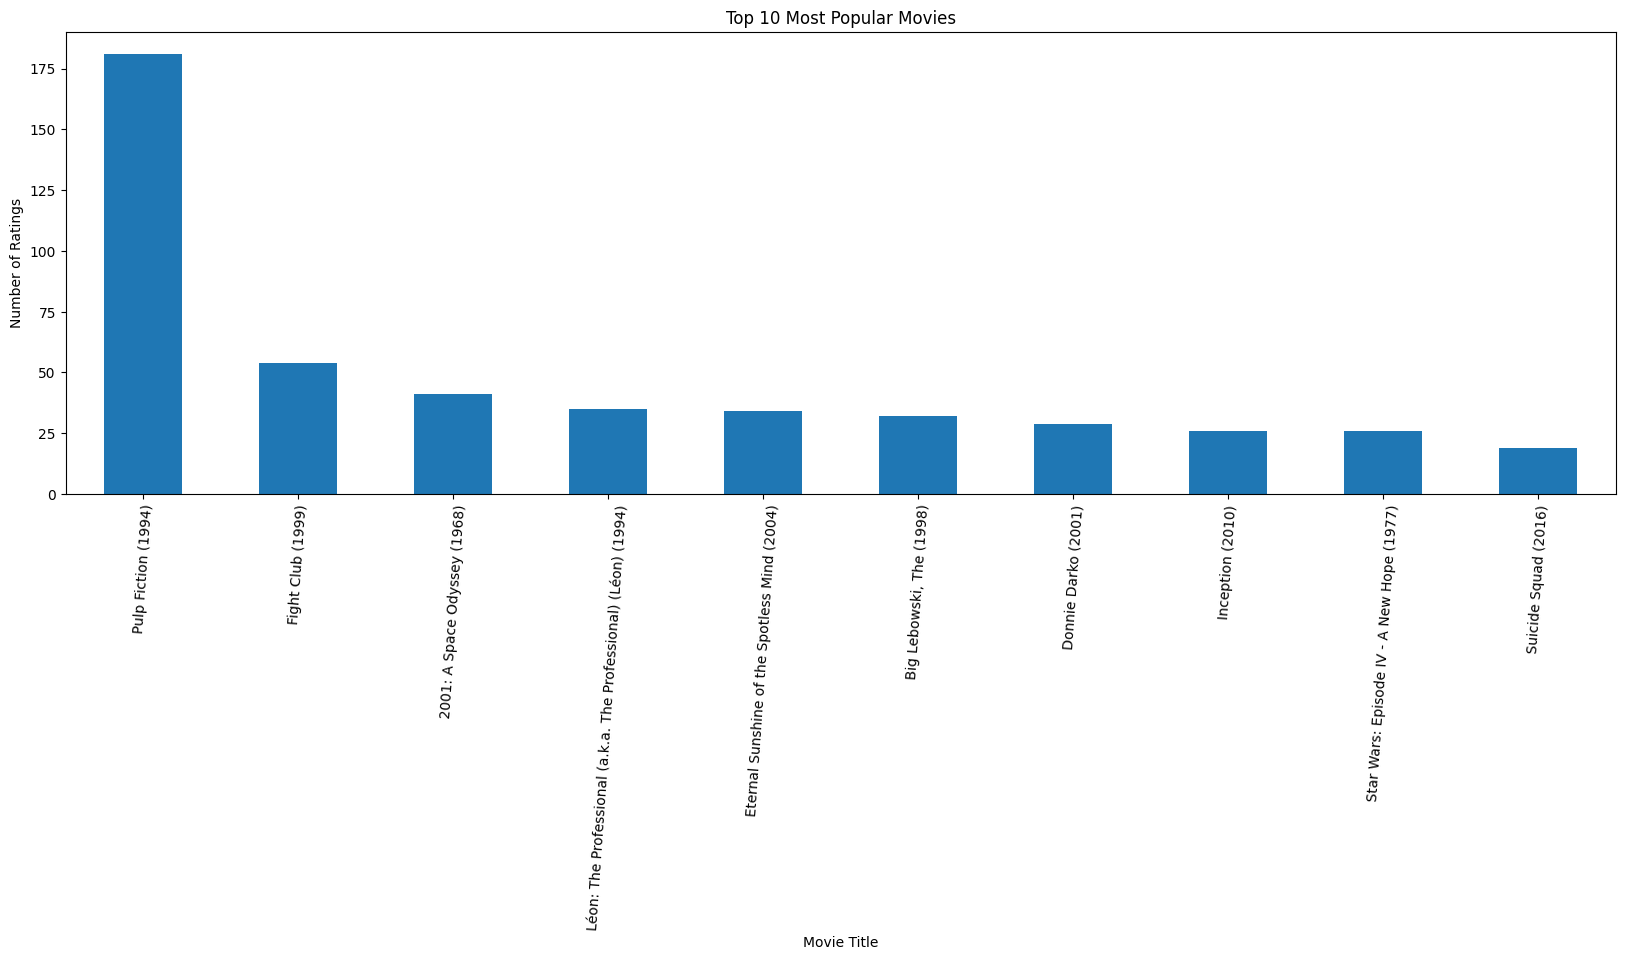

In [19]:
#most ratings falling between 3.6 and 4.6.
# Most Popular Movies (Top 10)
top_movies = combined_df['title'].value_counts().nlargest(10)
plt.figure(figsize=(20, 6))
top_movies.plot(kind='bar')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.title('Top 10 Most Popular Movies')
plt.xticks(rotation=86)
plt.show()

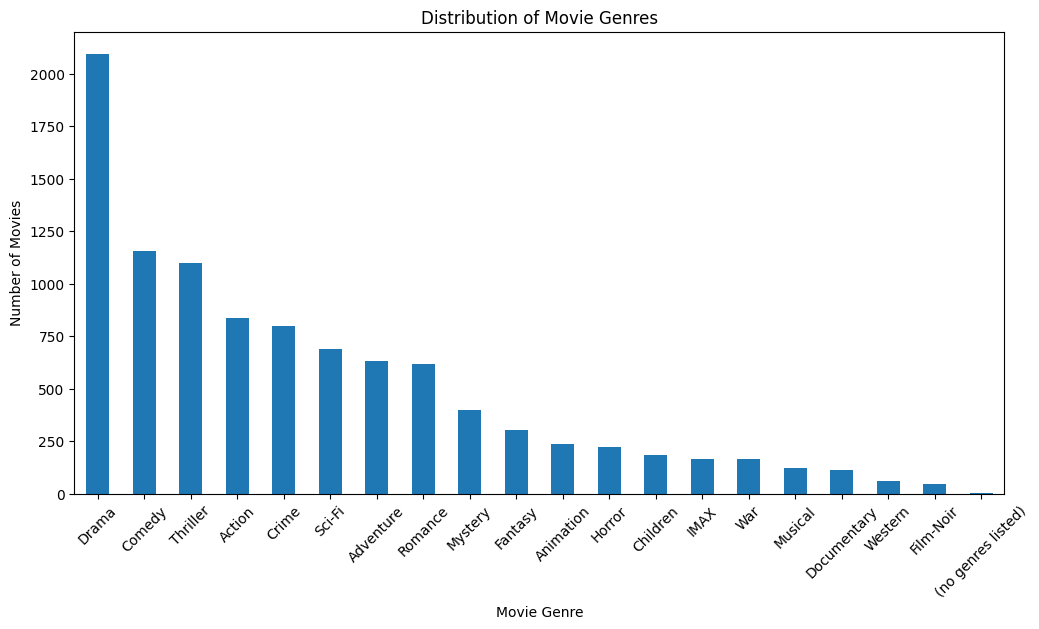

In [20]:
# Split the genres into a list and explode them into separate rows
combined_df['genres'] = combined_df['genres'].str.split('|')
exploded_genres = combined_df.explode('genres')

# Get the value counts for each genre (excluding NaN values)
genres_counts = exploded_genres['genres'].value_counts()

plt.figure(figsize=(12, 6))
genres_counts.plot(kind='bar')
plt.xlabel('Movie Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Genres')
plt.xticks(rotation=45)
plt.show()

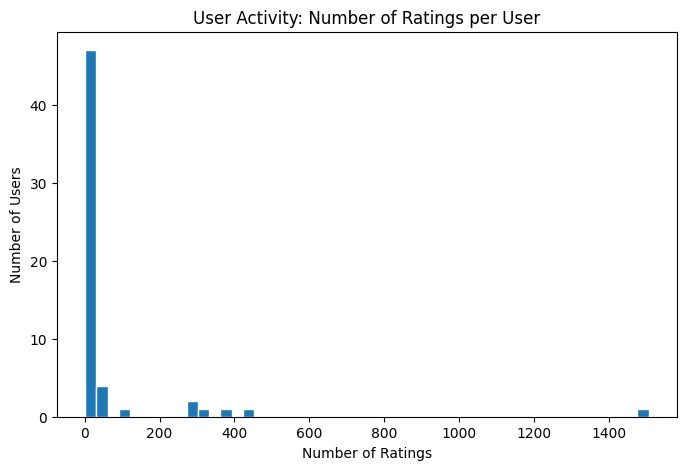

,userId,movieId,tag,tag_timestamp,rating,rating_timestamp,title,genres
1269,474,1035,Rogers and Hammerstein,2006-01-13 19:39:39,5.0,2000-11-19 20:44:54,"Sound of Music, The (1965)","[Musical, Romance]"
1806,474,3481,Nick Hornby,2006-01-13 19:38:13,5.0,2000-11-19 20:44:54,High Fidelity (2000),"[Comedy, Drama, Romance]"
1143,474,551,Christmas,2006-01-16 01:40:15,3.0,2000-11-19 20:44:54,"Nightmare Before Christmas, The (1993)","[Animation, Children, Fantasy, Musical]"
1144,474,551,Halloween,2006-01-16 01:40:15,3.0,2000-11-19 20:44:54,"Nightmare Before Christmas, The (1993)","[Animation, Children, Fantasy, Musical]"
1376,474,1259,Stephen King,2006-01-13 19:50:38,4.0,2000-11-19 20:44:54,Stand by Me (1986),"[Adventure, Drama]"
...,...,...,...,...,...,...,...,...
3339,573,6016,not seen,2007-08-08 16:00:53,4.0,2018-09-16 11:49:14,City of God (Cidade de Deus) (2002),"[Action, Adventure, Crime, Drama, Thriller]"
3340,573,6157,bad,2007-08-08 16:05:33,4.0,2018-09-16 11:49:14,Daredevil (2003),"[Action, Crime]"
3341,573,6157,Ben Affleck,2007-08-08 16:05:33,4.0,2018-09-16 11:49:14,Daredevil (2003),"[Action, Crime]"
3672,600,273,gothic,2009-03-22 16:24:24,4.0,2018-09-16 11:49:14,Mary Shelley's Frankenstein (Frankenstein) (1994),"[Drama, Horror, Sci-Fi]"


In [21]:
# User Activity Analysis (Number of Ratings per User)
user_rating_counts = combined_df['userId'].value_counts()
plt.figure(figsize=(8, 5))
plt.hist(user_rating_counts, bins=50, edgecolor='white')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.title('User Activity: Number of Ratings per User')
plt.show()

combined_df

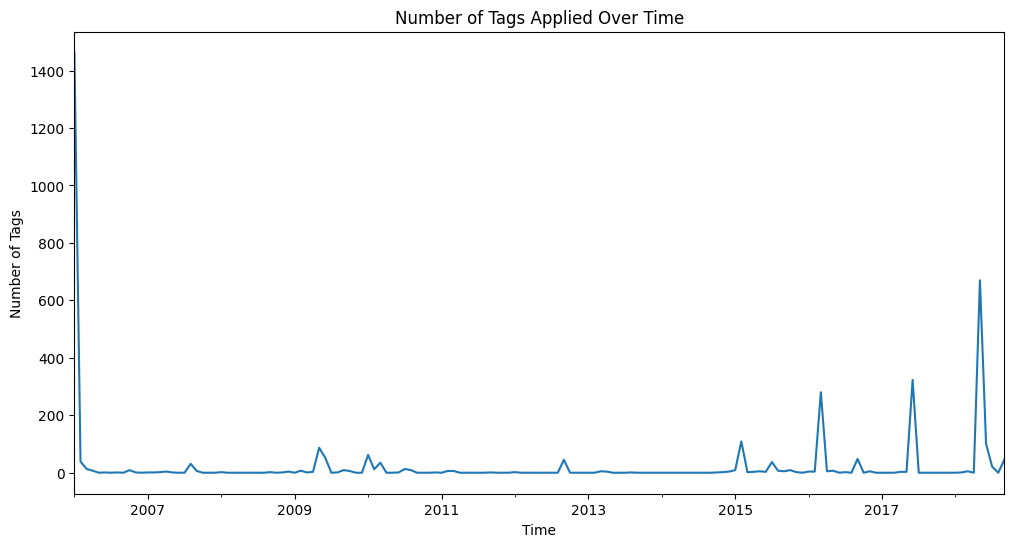

In [22]:
#The majority of users have rated a relatively small number of movies (between 0 and 200).

# Time-Based Analysis for Tags
# Sort the data by 'tag_timestamp'
combined_df.sort_values(by='tag_timestamp', inplace=True)

# Time-Based Analysis for Tags
tag_count_by_time = combined_df.groupby(pd.Grouper(key='tag_timestamp', freq='M')).size()

# Plot the number of tags applied over time
plt.figure(figsize=(12, 6))
tag_count_by_time.plot()
plt.xlabel('Time')
plt.ylabel('Number of Tags')
plt.title('Number of Tags Applied Over Time')
plt.show()

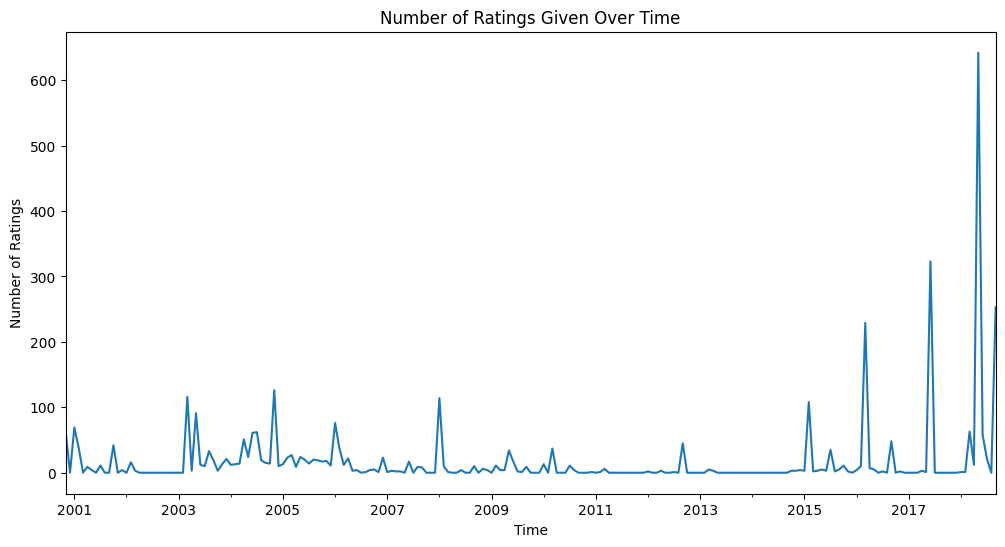

In [23]:
#Time-Based Analysis for Ratings

# Sort the data by 'rating_timestamp'
combined_df.sort_values(by='rating_timestamp', inplace=True)

# Time-Based Analysis for Ratings
rating_count_by_time = combined_df.groupby(pd.Grouper(key='rating_timestamp', freq='M')).size()

# Plot the number of ratings given over time
plt.figure(figsize=(12, 6))
rating_count_by_time.plot()
plt.xlabel('Time')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings Given Over Time')
plt.show()


In [24]:
# Group by movieId and get the maximum rating for each movie
highest_ratings = combined_df.groupby('movieId')['rating'].max().reset_index()

# Merge with the original dataframe to get the corresponding movie titles
highest_ratings = highest_ratings.merge(combined_df[['movieId', 'title']], on='movieId')

# Rename columns for clarity
highest_ratings.rename(columns={'rating': 'highest_rating'}, inplace=True)

# Display the result
highest_ratings.drop_duplicates(inplace=True)

highest_ratings

,movieId,highest_rating,title
0,1,4.0,Toy Story (1995)
3,2,4.0,Jumanji (1995)
7,3,2.5,Grumpier Old Men (1995)
9,5,1.5,Father of the Bride Part II (1995)
11,7,3.0,Sabrina (1995)
...,...,...,...
3668,183611,4.0,Game Night (2018)
3671,184471,3.5,Tomb Raider (2018)
3674,187593,4.0,Deadpool 2 (2018)
3677,187595,4.0,Solo: A Star Wars Story (2018)


In [25]:
from surprise import SVD,Dataset,Reader
from surprise.model_selection import train_test_split

# Create a Surprise Reader to parse the data
reader = Reader(rating_scale=(0.5, 5))

# Load the data into a Surprise Dataset
data = Dataset.load_from_df(combined_df[['userId', 'movieId', 'rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Initialize the SVD model
model = SVD()

# Train the model on the training set
model.fit(trainset)

# Get user recommendations for each user in the test set
user_recommendations = {}
for user_id, movie_id, _ in testset:
    if user_id not in user_recommendations:
        user_recommendations[user_id] = []
    predicted_rating = model.predict(user_id, movie_id).est
    user_recommendations[user_id].append((movie_id, predicted_rating))

# Sort the recommendations for each user based on predicted rating
for user_id, recommendations in user_recommendations.items():
    recommendations.sort(key=lambda x: x[1], reverse=True)

# Get the top N recommendations for each user
n = 5
user_top_recommendations = {user_id: recommendations[:n] for user_id, recommendations in user_recommendations.items()}

# Convert the recommendations to a DataFrame for easy viewing
user_recommendations_df = pd.DataFrame([(user_id, movie_id, predicted_rating) for user_id, recommendations in user_top_recommendations.items() for movie_id, predicted_rating in recommendations],
                                       columns=['userId', 'movieId', 'predicted_rating'])

# Merge with the original movie titles for clarity
user_recommendations_df = user_recommendations_df.merge(combined_df[['movieId', 'title']], on='movieId')

user_recommendations_df.drop_duplicates(inplace=True)
# Display the result
user_recommendations_df


,userId,movieId,predicted_rating,title
0,474,6333,4.546922,X2: X-Men United (2003)
5,474,318,4.489428,"Shawshank Redemption, The (1994)"
9,474,1196,4.417850,Star Wars: Episode V - The Empire Strikes Back...
19,477,1196,4.951238,Star Wars: Episode V - The Empire Strikes Back...
29,474,2762,4.229449,"Sixth Sense, The (1999)"
...,...,...,...,...
1940,356,44889,4.193498,Reefer Madness: The Movie Musical (2005)
1941,509,80834,3.854445,Sintel (2010)
1947,520,3039,4.067008,Trading Places (1983)
1949,106,4896,4.139802,Harry Potter and the Sorcerer's Stone (a.k.a. ...


In [27]:
from surprise import accuracy

test_predictions = model.test(testset)

mae = accuracy.mae(test_predictions)
print("MAE:", mae)

rmse = accuracy.rmse(test_predictions)
print("RMSE:", rmse)


MAE:  0.3464
MAE: 0.34638857422489505
RMSE: 0.5761
RMSE: 0.5761056488383494
